<a href="https://colab.research.google.com/github/federicocampo/CMEPDA-Project/blob/Prime_modifiche/DANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input, LayerNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import BinaryAccuracy, AUC

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold


# DATASET

In [31]:
def siteslist(readfile , site_name_column = 'SITE'):
	#Create a numpy array with shape = (N_site, 2) with 
	#the name of the site in the first column and the numeric label in the second
	
	mydataframe = readfile[site_name_column]
	dummydf = pd.get_dummies(mydataframe)
	
	sites_list = [] 
	for site in dummydf.columns: #Iteration on each site's name
		sites_list.append(site)
			
	sites_list = np.array(sites_list)
	return sites_list



> Harmonized



In [32]:
df = pd.read_csv('gdrive/MyDrive/NEW_features_Non_Normalizzate_A1+2_harmonized_male.csv')


sites_list = siteslist(df)
#sites_list = ['NYU_A', 'STANFORD', 'U_MIA_A', 'KKI', 'OHSU', 'KKI_A', 'OHSU_A', 'GU_A', 'SU_B', 'UCLA_3']


df = df.loc[df['SITE'].isin(sites_list)]
df = df.reset_index(drop = True)


#Create a column with site names converted into numbers
for i, name in enumerate(sites_list):
  df.loc[df.SITE == name , 'SITE_LABEL'] =  int(i)

#Change columns order: put the last as first
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

#Create a df with only features' columns
df_features = df.copy()
df_features = df.iloc[:, 6:]
df_features =(df_features-df_features.min())/(df_features.max()-df_features.min())

#Extracting dataset X, y
X = np.array(df_features.values)

y = df.DX_GROUP.to_numpy(dtype = 'int64')
y[y == -1] = int(0)


y_site = df.SITE_LABEL.to_numpy()
from sklearn.preprocessing import OneHotEncoder
y_site = y_site.reshape(-1, 1)
enc = OneHotEncoder()
y_site = enc.fit_transform(y_site).toarray()


X_train, X_val, y_train, y_val, ysite_train, ysite_val  = train_test_split(X, y,y_site, random_state = 55, shuffle = True, test_size = 0.2)

> Not harmonized

In [4]:
df = pd.read_csv('gdrive/MyDrive/NEW_features_Non_Normalizzate_A1+2_male.csv')


sites_list = siteslist(df)

#sites_list = ['NYU_A', 'STANFORD', 'U_MIA_A', 'KKI', 'OHSU', 'KKI_A', 'OHSU_A', 'GU_A', 'SU_B', 'UCLA_3']
#df = df.loc[df['SITE'].isin(sites_list)]
#df = df.reset_index(drop = True)


#Create a column with site names converted into numbers
for i, name in enumerate(sites_list):
  df.loc[df.SITE == name , 'SITE_LABEL'] =  int(i)

#Change columns order: put the last as first
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

#Create a df with only features' columns
df_features = df.copy()
df_features = df.iloc[:, 8:]
df_features =(df_features-df_features.min())/(df_features.max()-df_features.min())

#Extracting dataset X, y
X = np.array(df_features.values)

y = df.DX_GROUP.to_numpy(dtype = 'int64')
y[y == -1] = int(0)


y_site = df.SITE_LABEL.to_numpy()
from sklearn.preprocessing import OneHotEncoder
y_site = y_site.reshape(-1, 1)
enc = OneHotEncoder()
y_site = enc.fit_transform(y_site).toarray()


X_train, X_val, y_train, y_val, ysite_train, ysite_val  = train_test_split(X, y,y_site, random_state = 55, shuffle = True, test_size = 0.2)


# DANN

In [5]:
batch_size = 64

#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, (y_train, ysite_train)))
train_dataset = train_dataset.shuffle(buffer_size=1024).shuffle(1000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=1024).shuffle(1000).batch(batch_size)


In [33]:
@tf.custom_gradient
def gradient_reverse_func(x, lamda=0.5):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad

class GradientReversalLayer(Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=0.5):
        return gradient_reverse_func(x, lamda)


In [34]:
final_sites_nodes = len(sites_list)

# Adversarial Neural Network
class DANN(Model):

  def __init__(self):
      super().__init__()

      self.features_layer0 = Dense(64, activation = 'relu')
      self.features_layer1 = Dense(28, activation='relu')


      self.batchnorm0 = BatchNormalization()
      self.batchnorm1 = BatchNormalization()
      self.batchnorm2 = BatchNormalization()

      #Label pred
      #self.label_layer0 = Dense(64, activation = 'relu')
      self.label_layer1 = Dense(1, activation = 'sigmoid')

      #Site pred
      self.site_layer0 = GradientReversalLayer()
      self.site_layer1 = Dense(64, activation = 'relu')
      self.site_layer2 = Dense(final_sites_nodes, activation = 'sigmoid')



  def call(self, inputs, training = True,  only_labels = False):
    x = inputs
    x = self.features_layer0(x)
    x = self.batchnorm0(x)
    x = self.features_layer1(x, training = training)
    x = self.batchnorm1(x)
    features = x
    #Label predictor
    lab = self.label_layer1(x)
  
    if only_labels:
      return lab
    else: 
      site_x = self.site_layer0(x)
      site_x = self.site_layer1(site_x)
      site = self.site_layer2(site_x)
      return lab, site
    
  def compile(self, lab_optimizer, site_optimizer, loss_fn):
    self.lab_optimizer = lab_optimizer
    self.site_optimizer = site_optimizer
    self.loss_fn = loss_fn
  

  def train(self, train_dataset, only_labels = True, only_train = False):
    epochs = 20
    for epoch in range(epochs):
        #print("\nStart of epoch %d" % (epoch,))
        accuracy_array = []
        loss_array = []
        # Iterate over the batches of the dataset.
        #for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        for step, (x_batch_train, (y_batch_train, ysite_batch_train)) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
  
                if only_labels:
                  logits = model(x_batch_train, training=True, only_labels = only_labels)  # Logits for this minibatch
                  loss_value = custom_loss(y_batch_train, logits)
                  
                else:
                  logits, logits2 = model(x_batch_train, training=True, only_labels = only_labels)  # Logits for this minibatch
                  loss_value = custom_loss(y_batch_train, logits, ysite_batch_train, logits2)  

            loss_array.append(loss_value)

            grads = tape.gradient(loss_value, model.trainable_weights)

            self.lab_optimizer.apply_gradients(zip(grads, model.trainable_weights))
            #self.site_optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
            #Metrics: accuracy or AUC 
            train_acc_metric.update_state(y_batch_train, logits)

        train_acc = train_acc_metric.result()
        print(f'Epoch {epoch}: Metric = {train_acc} \t Loss = {np.mean(loss_array)}')
        train_acc_metric.reset_states()

        if only_train:
          val_acc = self.validation(val_dataset, model)
          print(val_acc)




  def validation(self, val_dataset, model):
    val_acc_array = []
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
        val_acc = val_acc_metric.result()
        val_acc_array.append(val_acc)
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
    mean_val_acc = np.mean(val_acc_array)
    return mean_val_acc




In [40]:
def custom_loss(l_logits, labels, d_logits = None, domain = None):
  
  def loss_func(y_pred, y_true):
    return BinaryCrossentropy()(y_pred, y_true)
    
  if d_logits is None:
      return loss_func(l_logits, labels)
  else:
      return loss_func(l_logits, labels) + loss_func(d_logits, domain)
      #return loss_func(l_logits, labels), loss_func(d_logits, domain)
      

In [ ]:
model = DANN()
model.compile(lab_optimizer = SGD(), site_optimizer = SGD(), loss_fn = custom_loss)
#optimizer = SGD()

train_acc_metric = AUC()
val_acc_metric = BinaryAccuracy()

model.train(train_dataset, only_labels = False)

Epoch 0: Metric = 0.5133101344108582 	 Loss = 1.6101927757263184
Epoch 1: Metric = 0.5698729157447815 	 Loss = 1.5057567358016968
Epoch 2: Metric = 0.6048631072044373 	 Loss = 1.4584096670150757
Epoch 3: Metric = 0.6189361810684204 	 Loss = 1.4247357845306396
Epoch 4: Metric = 0.629096508026123 	 Loss = 1.406261682510376
Epoch 5: Metric = 0.6551343202590942 	 Loss = 1.3749656677246094
Epoch 6: Metric = 0.6628903150558472 	 Loss = 1.3574893474578857
Epoch 7: Metric = 0.6888772249221802 	 Loss = 1.3320521116256714
Epoch 8: Metric = 0.702174723148346 	 Loss = 1.3126773834228516
Epoch 9: Metric = 0.7179053425788879 	 Loss = 1.293608546257019
Epoch 10: Metric = 0.7335411310195923 	 Loss = 1.2699648141860962
Epoch 11: Metric = 0.7361835837364197 	 Loss = 1.258834719657898
Epoch 12: Metric = 0.749655544757843 	 Loss = 1.2412294149398804
Epoch 13: Metric = 0.763641893863678 	 Loss = 1.2220560312271118
Epoch 14: Metric = 0.7719274163246155 	 Loss = 1.2081629037857056
Epoch 15: Metric = 0.778739

[]

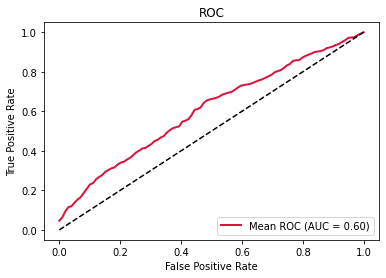

In [42]:
aucs = []
fprs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

kfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42).split(X, y)
for k, (train, test) in enumerate(kfold):
  X_train = np.array(X[train])
  y_train = np.array(y[train])
  ysite_train = np.array(y_site[train])

  X_test = np.array(X[test])
  y_test = np.array(y[test])

  batch_size = 64

  #train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, (y_train, ysite_train)))
  train_dataset = train_dataset.shuffle(buffer_size=1024).shuffle(1000).batch(batch_size)

  test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  test_dataset = test_dataset.shuffle(buffer_size=1024).shuffle(1000).batch(batch_size)

  model = DANN()
  model.compile(lab_optimizer = SGD(), site_optimizer = SGD(), loss_fn = custom_loss)

  train_acc_metric = AUC()
  val_acc_metric = BinaryAccuracy()

  model.train(only_labels = False, train_dataset = train_dataset)

  try:
    y_pred = model.predict(X_test).ravel()
  except AttributeError:
    y_pred = model.predict(X_test)
    y_pred = y_pred[0].ravel()


  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  model_auc = auc(fpr, tpr)
  print(f'AUC on fold {k} = {model_auc : .2f}')
  aucs.append(model_auc)
  fprs.append(fpr)

  tprs.append(np.interp(mean_fpr, fpr, tpr))

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='crimson', label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',color = 'black') # Bisector line
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('ROC')
plt.legend(loc="lower right")

plt.plot()